Training a KNN model to predict starter status using performance stats. Then, scanning through bench players to find those whose stats are very similar to starters.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [35]:
#read in data
df = pd.read_csv("cleaned_nba_stats(in).csv")
print(df.head())
print(df.columns)
print(df.dtypes)

   SCOPE   TM   RS               NAME   G  GS   MIN   FG   FGA  FG_PCT  ...  \
0  Total   NY  ACT  Achiuwa, Precious  56   9  1137  156   309   0.505  ...   
1  Total  HOU  ACT      Adams, Steven  57   3   777   89   163   0.546  ...   
2  Total  MIA  ACT       Adebayo, Bam  78  78  2674  540  1113   0.485  ...   
3  Total  TOR  ACT      Agbaji, Ochai  63  44  1701  260   519   0.501  ...   
4  Total  MEM  ACT      Aldama, Santi  65  16  1660  313   648   0.483  ...   

   AST   PF  DQ  STL   TO  BLK   PTS   PPG  HI  Starter  
0   53   77   1   45   43   42   361   6.4  26        0  
1   65   58   0   22   53   28   221   3.9  14        0  
2  337  162   0   98  161   53  1410  18.1  34        1  
3   97  120   1   54   53   29   653  10.4  24        1  
4  188   76   0   52   71   29   811  12.5  29        0  

[5 rows x 29 columns]
Index(['SCOPE', 'TM', 'RS', 'NAME', 'G', 'GS', 'MIN', 'FG', 'FGA', 'FG_PCT',
       'FG3', 'FG3A', 'FG3_PCT', 'FT', 'FTA', 'FT_PCT', 'OFF', 'DEF', 'TREB',

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

features = ['PPG', 'AST', 'TREB', 'FG_PCT', "BLK"] #independent variables
X = df[features] 
y = df['Starter']  # dependent variable

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Accuracy Elbow Plot

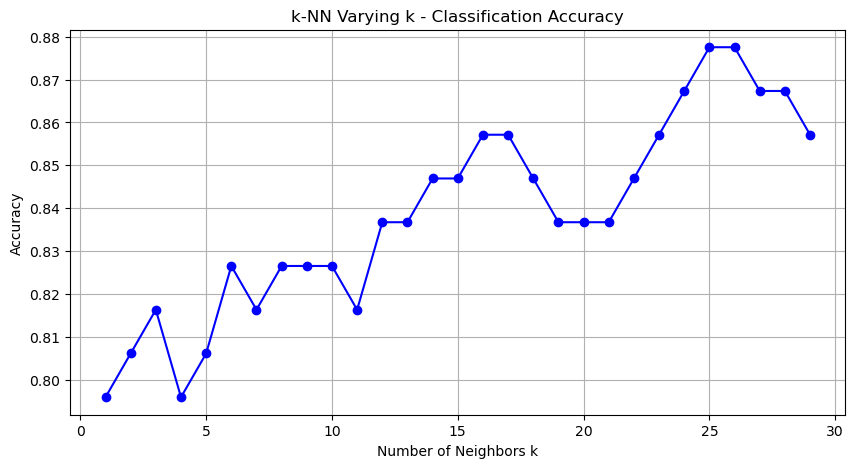

25

In [40]:
# Split into train/test
from sklearn.model_selection import train_test_split

# Random 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2,random_state=42)


from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Range of k values to test
k_values = range(1, 30)
accuracies = []

# Test classification accuracy for each k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))
     
# Plotting accuracy vs k
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('k-NN Varying k - Classification Accuracy')
plt.xlabel('Number of Neighbors k')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Find the best k (max accuracy)
best_k = k_values[np.argmax(accuracies)]
best_k

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.91        59
           1       0.97      0.72      0.82        39

    accuracy                           0.88        98
   macro avg       0.90      0.85      0.86        98
weighted avg       0.89      0.88      0.87        98

Confusion Matrix:
[[58  1]
 [11 28]]
AUC Score: 0.9348


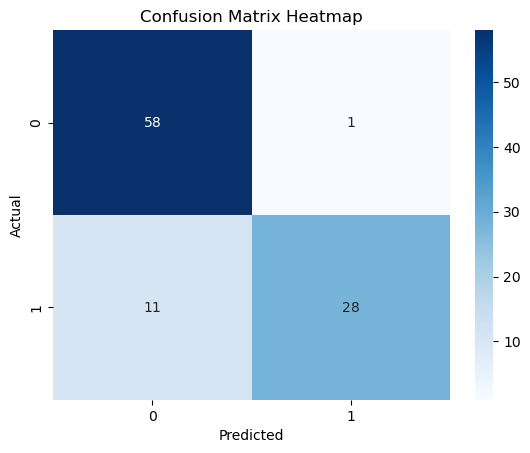

In [41]:
# Train final model with best k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

# Evaluate on test set
y_pred = knn.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import roc_auc_score

# AUC score
y_proba = knn.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)
print(f"AUC Score: {auc:.4f}")


# Confusion matrix heatmap
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [42]:
import pandas as pd
from IPython.display import display  

# Bench players who are statistically similar to known starters
print("\nBench players similar to starters:")

bench_indices = df[df['Starter'] == 0].index
similar_bench_players = []

for idx in bench_indices:
    distances, neighbor_indices = knn.kneighbors([X_scaled[idx]])
    neighbor_Starters = df.iloc[neighbor_indices[0]]['Starter']
    num_Starters = neighbor_Starters.sum()
    # Players with 3 or more neighbors who are starters, and have above average PPG 
    if num_Starters >= 3 and df.iloc[idx]['PPG'] > X['PPG'].mean():
        similar_bench_players.append(df.iloc[idx][['NAME', 'PPG']])

# Dataframe
similar_df = pd.DataFrame(similar_bench_players)
display(similar_df)


Bench players similar to starters:


,NAME,PPG
4,"Aldama, Santi",12.5
7,"Allen, Grayson",10.5
9,"Alvarado, Jose",10.3
32,"Beasley, Malik",16.2
37,"Bogdanovic, Bogdan",10.9
41,"Boston, Brandon Jr.",10.7
42,"Boucher, Chris",10.0
51,"Brooks, Keion Jr.",9.8
74,"Champagnie, Julian",9.9
82,"Clarkson, Jordan",16.2


In [45]:
## Cross validated Accuracy Plot

In [46]:
# Check for unbalanced data
print(df['Starter'].value_counts())
print(df['Starter'].value_counts(normalize=True))
#moderately unbalanced 

Starter
0    311
1    178
Name: count, dtype: int64
Starter
0    0.635992
1    0.364008
Name: proportion, dtype: float64


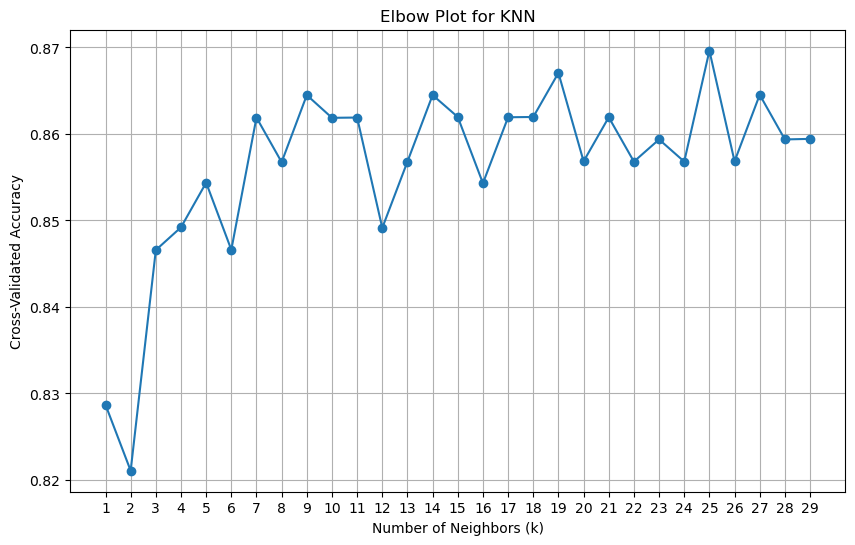

25

In [48]:
# Split into train/test
# Using stratified split to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Determine optimal k using cross-validated accuracy
# Range of k values to test
k_range = range(1, 30)
cv_scores = [cross_val_score(KNeighborsClassifier(n_neighbors=k), X_train, y_train, cv=5, scoring='accuracy').mean() for k in k_range]

# Plot elbow plot
plt.figure(figsize=(10, 6))
plt.plot(k_range, cv_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Elbow Plot for KNN')
plt.grid(True)
plt.xticks(k_range)
plt.show()

# Find best k 
best_k = k_range[np.argmax(cv_scores)]
best_k

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89        62
           1       0.89      0.67      0.76        36

    accuracy                           0.85        98
   macro avg       0.86      0.81      0.82        98
weighted avg       0.85      0.85      0.84        98

Confusion Matrix:
[[59  3]
 [12 24]]


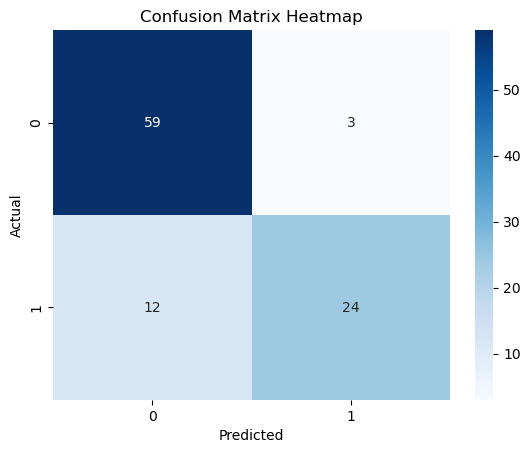

In [51]:
# Train final model with the best k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

# Evaluate on test set
y_pred = knn.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Confusion matrix heatmap
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [53]:
from sklearn.metrics import roc_auc_score

# AUC score
y_proba = knn.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)
print(f"AUC Score: {auc:.4f}")

AUC Score: 0.8963


In [54]:
import pandas as pd
from IPython.display import display  

# Bench players who are statistically similar to known starters
print("\nBench players similar to starters:")

bench_indices = df[df['Starter'] == 0].index
similar_bench_players = []

for idx in bench_indices:
    distances, neighbor_indices = knn.kneighbors([X_scaled[idx]])
    neighbor_Starters = df.iloc[neighbor_indices[0]]['Starter']
    num_Starters = neighbor_Starters.sum()
    # Players with 3 or more neighbors who are starters, and have above average PPG 
    if num_Starters >= 3 and df.iloc[idx]['PPG'] > X['PPG'].mean():
        similar_bench_players.append(df.iloc[idx][['NAME', 'PPG']])

# Dataframe
similar_df = pd.DataFrame(similar_bench_players)
display(similar_df)


Bench players similar to starters:


,NAME,PPG
4,"Aldama, Santi",12.5
7,"Allen, Grayson",10.5
9,"Alvarado, Jose",10.3
32,"Beasley, Malik",16.2
37,"Bogdanovic, Bogdan",10.9
41,"Boston, Brandon Jr.",10.7
42,"Boucher, Chris",10.0
51,"Brooks, Keion Jr.",9.8
74,"Champagnie, Julian",9.9
82,"Clarkson, Jordan",16.2


## GridSearch with 5-fold CV

In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': list(range(1, 31)),         
    'weights': ['uniform', 'distance'],       
    'p': [1, 2]}                                 


# Setup GridSearch with 5-fold CV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit to entire dataset w/ scaled features
grid_search.fit(X_scaled, y)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Best model from GridSearchCV
best_knn = grid_search.best_estimator_

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Fit model
best_knn.fit(X_train, y_train)

# Predictions
y_pred = best_knn.predict(X_test)
y_proba = best_knn.predict_proba(X_test)[:, 1] 

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# AUC Score
auc = roc_auc_score(y_test, y_proba)
print(f"AUC Score: {auc:.4f}")




Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        62
           1       0.79      0.72      0.75        36

    accuracy                           0.83        98
   macro avg       0.82      0.80      0.81        98
weighted avg       0.82      0.83      0.82        98

Confusion Matrix:
[[55  7]
 [10 26]]
AUC Score: 0.8741


## Cross Validated F1 Score

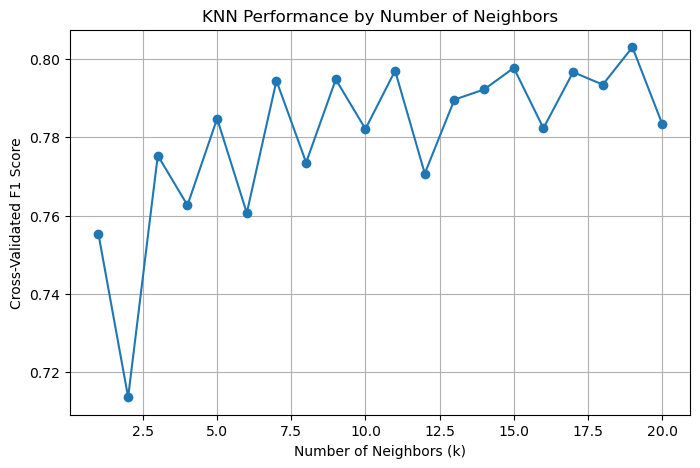

In [60]:
k_range = range(1, 21)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='f1')
    scores.append(cv_scores.mean())
# Plot F1 score vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_range, scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validated F1 Score')
plt.title('KNN Performance by Number of Neighbors')
plt.grid(True)
plt.show()

Best k based on F1 score: 19
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        62
           1       0.80      0.67      0.73        36

    accuracy                           0.82        98
   macro avg       0.81      0.78      0.79        98
weighted avg       0.81      0.82      0.81        98

Confusion Matrix:
[[56  6]
 [12 24]]


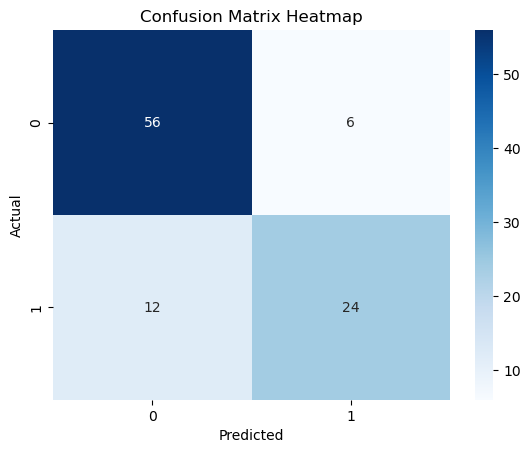

In [61]:
# Print best k
best_k = k_range[np.argmax(scores)]
print(f"Best k based on F1 score: {best_k}")

# Train final model with best k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

# Evaluate on test set
y_pred = knn.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Confusion matrix heatmap
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [62]:
from sklearn.metrics import roc_auc_score

# AUC score
y_proba = knn.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)
print(f"AUC Score: {auc:.4f}")

AUC Score: 0.8914


In [63]:
# Bench players who are statistically similar to known starters
print("\nBench players similar to starters:")

bench_indices = df[df['Starter'] == 0].index

for idx in bench_indices:
    distances, neighbor_indices = knn.kneighbors([X_scaled[idx]])
    neighbor_Starters = df.iloc[neighbor_indices[0]]['Starter']
    num_Starters = neighbor_Starters.sum()
    if num_Starters >= 5 and df.iloc[idx]['PPG'] > X['PPG'].mean():
        print(df.iloc[idx][['NAME', 'PPG']])



Bench players similar to starters:
NAME    Aldama, Santi
PPG              12.5
Name: 4, dtype: object
NAME    Alvarado, Jose
PPG               10.3
Name: 9, dtype: object
NAME    Beasley, Malik
PPG               16.2
Name: 32, dtype: object
NAME    Boston, Brandon Jr.
PPG                    10.7
Name: 41, dtype: object
NAME    Boucher, Chris
PPG               10.0
Name: 42, dtype: object
NAME    Brooks, Keion Jr.
PPG                   9.8
Name: 51, dtype: object
NAME    Champagnie, Julian
PPG                    9.9
Name: 74, dtype: object
NAME    Clarkson, Jordan
PPG                 16.2
Name: 82, dtype: object
NAME    DiVincenzo, Donte
PPG                  11.6
Name: 106, dtype: object
NAME    Dinwiddie, Spencer
PPG                   11.1
Name: 111, dtype: object
NAME    Eason, Tari
PPG            12.1
Name: 121, dtype: object
NAME    Evbuomwan, Tosan
PPG                  9.8
Name: 130, dtype: object
NAME    Grimes, Quentin
PPG                14.6
Name: 161, dtype: object
NAME    Hen

In [64]:
import pandas as pd
from IPython.display import display  

# Bench players who are statistically similar to known starters
print("\nBench players similar to starters:")

bench_indices = df[df['Starter'] == 0].index
similar_bench_players = []

for idx in bench_indices:
    distances, neighbor_indices = knn.kneighbors([X_scaled[idx]])
    neighbor_Starters = df.iloc[neighbor_indices[0]]['Starter']
    num_Starters = neighbor_Starters.sum()
    # Players with 3 or more neighbors who are starters, and have above average PPG 
    if num_Starters >= 3 and df.iloc[idx]['PPG'] > X['PPG'].mean():
        similar_bench_players.append(df.iloc[idx][['NAME', 'PPG']])

# Dataframe
similar_df = pd.DataFrame(similar_bench_players)
display(similar_df)



Bench players similar to starters:


,NAME,PPG
4,"Aldama, Santi",12.5
7,"Allen, Grayson",10.5
9,"Alvarado, Jose",10.3
32,"Beasley, Malik",16.2
37,"Bogdanovic, Bogdan",10.9
41,"Boston, Brandon Jr.",10.7
42,"Boucher, Chris",10.0
51,"Brooks, Keion Jr.",9.8
74,"Champagnie, Julian",9.9
82,"Clarkson, Jordan",16.2
